Clustering

In [1]:
import h5py
import numpy as np
from collections import Counter

import torch
from torchvision import models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy.sparse.linalg import eigsh
from scipy.sparse import issparse
from sklearn.utils.validation import check_array
from PIL import Image
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import pairwise_kernels
import numbers
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_fscore_support, f1_score

import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
import os
import openpyxl 
from datetime import datetime

/vol/bitbucket/wr323/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
'''
The Spectral Clustering code is based on Scikit-learn:
Scikit-learn: Machine Learning in Python
Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
          and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
          and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
          Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E., Journal of Machine Learning Research
https://github.com/scikit-learn/scikit-learn
'''

In [3]:
# --- CONFIGURATION ---
rbf_gamma = 0.5
dist_to_centroid_metric = 'manhattan'
h5py_input_path = '/vol/bitbucket/wr323/4Wutikorn/4Wutikorn/combined_inp_filter_224x288.hdf5'
h5py_output_path = '/vol/bitbucket/wr323/4Wutikorn/4Wutikorn/ResNetTrained_spectral_sampling_normalized_data_50_50_spectral_distance_RBF_0_5_manhattan_embedding50_run1.hdf5'
excel_file_path = "Results/Ultrasound ResNet18 Spectral Dataset ResNet50TrainedEmbedding Normalized 50 50 Spectral Distance RBF 0_5 Manhattan Result.xlsx" 
# result_save_dir = "/vol/bitbucket/wr323/Result 2017 Pre-Trained-CNN and Spectral HDF5" 
num_clusters = 50
num_key_clusters = 50
debugging = True  # Set to True to enable debugging outputs
# --- DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MODEL SETUP ---

# Path to your saved model file
model = models.resnet50()  # Create a ResNet50 instance
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)  # Match your model's classifier
model.load_state_dict(torch.load('/vol/bitbucket/wr323/Efficient_Image_Subset_Selection/Ultrasound/best_ultrasound_resnet50.pth')) 
model = torch.nn.Sequential(*list(model.children())[:-1])
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cuda


In [4]:
# The Spectral Clustering implementation is from Scikit-learn. Our method use functions from Scikit-learn to access spectral embedding, which otherwise is inaccessible.
# The Spectral embedding is used to calculate distance in spectral embedding to the centroid and for keyframe selection.
# The following functions are from Scikit-learn: _init_arpack_v0, check_random_state, _set_diag, _deterministic_vector_sign_flip, and get_spectral_embedding (affinity matrix and Laplacian matrix)
# https://github.com/scikit-learn/scikit-learn/tree/70fdc843a4b8182d97a3508c1a426acc5e87e980

def _init_arpack_v0(size, random_state):
    """Initialize the starting vector for iteration in ARPACK functions.

    Initialize a ndarray with values sampled from the uniform distribution on
    [-1, 1]. This initialization model has been chosen to be consistent with
    the ARPACK one as another initialization can lead to convergence issues.

    Parameters
    ----------
    size : int
        The size of the eigenvalue vector to be initialized.

    random_state : int, RandomState instance or None, default=None
        The seed of the pseudo random number generator used to generate a
        uniform distribution. If int, random_state is the seed used by the
        random number generator; If RandomState instance, random_state is the
        random number generator; If None, the random number generator is the
        RandomState instance used by `np.random`.

    Returns
    -------
    v0 : ndarray of shape (size,)
        The initialized vector.
    """
    random_state = check_random_state(random_state)
    v0 = random_state.uniform(-1, 1, size)
    return v0

def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.

    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.

    Returns
    -------
    :class:`numpy:numpy.random.RandomState`
        The random state object based on `seed` parameter.

    Examples
    --------
    >>> from sklearn.utils.validation import check_random_state
    >>> check_random_state(42)
    RandomState(MT19937) at 0x...
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState instance" % seed
    )

def _set_diag(laplacian, value, norm_laplacian):
    """Set the diagonal of the laplacian matrix and convert it to a
    sparse format well suited for eigenvalue decomposition.

    Parameters
    ----------
    laplacian : {ndarray, sparse matrix}
        The graph laplacian.

    value : float
        The value of the diagonal.

    norm_laplacian : bool
        Whether the value of the diagonal should be changed or not.

    Returns
    -------
    laplacian : {array, sparse matrix}
        An array of matrix in a form that is well suited to fast
        eigenvalue decomposition, depending on the band width of the
        matrix.
    """
    n_nodes = laplacian.shape[0]
    # We need all entries in the diagonal to values
    if not issparse(laplacian):
        if norm_laplacian:
            laplacian.flat[:: n_nodes + 1] = value
    else:
        laplacian = laplacian.tocoo()
        if norm_laplacian:
            diag_idx = laplacian.row == laplacian.col
            laplacian.data[diag_idx] = value
        # If the matrix has a small number of diagonals (as in the
        # case of structured matrices coming from images), the
        # dia format might be best suited for matvec products:
        n_diags = np.unique(laplacian.row - laplacian.col).size
        if n_diags <= 7:
            # 3 or less outer diagonals on each side
            laplacian = laplacian.todia()
        else:
            # csr has the fastest matvec and is thus best suited to
            # arpack
            laplacian = laplacian.tocsr()
    return laplacian

def _deterministic_vector_sign_flip(u):
    """Modify the sign of vectors for reproducibility.

    Flips the sign of elements of all the vectors (rows of u) such that
    the absolute maximum element of each vector is positive.

    Parameters
    ----------
    u : ndarray
        Array with vectors as its rows.

    Returns
    -------
    u_flipped : ndarray with same shape as u
        Array with the sign flipped vectors as its rows.
    """
    max_abs_rows = np.argmax(np.abs(u), axis=1)
    signs = np.sign(u[range(u.shape[0]), max_abs_rows])
    u *= signs[:, np.newaxis]
    return u

In [5]:

def visualize_tsne(spectral_embeddings, embedding_clusters, class_name):
    """
    Visualizes spectral embeddings using T-SNE, colored by cluster labels.
    """

    tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random', random_state=0)
    tsne_embeddings = tsne.fit_transform(spectral_embeddings)

    plt.figure(figsize=(12, 10))  # Increase figure size
    cmap = mpl.colormaps['tab20']  # Use a colormap with more colors
    unique_clusters = np.unique(embedding_clusters)
    markers = ['o', 's', '^', 'v', 'D', 'P', 'X', 'h', '+', 'p'] * (len(unique_clusters) // 10 + 1)  # Cycle through markers
    for i, cluster in enumerate(unique_clusters):
        cluster_points = tsne_embeddings[embedding_clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=cmap(i%20), marker=markers[i], label=f'Cluster {cluster}', s=30)  # Adjust marker size

    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
    plt.title(f'T-SNE Visualization of Spectral Embeddings for Class: {class_name}')
    plt.show()

def visualize_tsne_top_clusters(spectral_embeddings, embedding_clusters, class_name, closest_image_indices, top_n_clusters=10):
    """
    Visualizes T-SNE of the top N clusters, highlighting selected keyframes.

    Args:
        spectral_embeddings (array): Spectral embeddings of the images.
        embedding_clusters (array): Cluster assignments for each image.
        class_name (str): Name of the class being processed.
        closest_image_indices (list): Indices of the selected keyframes.
        top_n_clusters (int, optional): Number of top clusters to visualize. Defaults to 20.
    """

    tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random', random_state=0)
    tsne_embeddings = tsne.fit_transform(spectral_embeddings)

    plt.figure(figsize=(12, 10))
    cmap = mpl.colormaps['tab20']
    unique_clusters = np.unique(embedding_clusters)

    # Determine top clusters based on frequency
    cluster_counts = Counter(embedding_clusters)
    largest_clusters = cluster_counts.most_common(top_n_clusters)

    # Plot top clusters
    markers = ['o', 's', '^', 'v', 'D', 'P', 'X', 'h', '+', 'p'] * (top_n_clusters // 9 + 1)  # Cycle through markers
    alpha = 1 / 3
    # print("closest_image_indices: ", closest_image_indices)
    for i, (cluster_idx, _) in enumerate(largest_clusters):
        # print("cluster_idx: ", cluster_idx)
        cluster_indices = np.where(embedding_clusters == cluster_idx)[0]
        # print("cluster_indices: ", cluster_indices)
        cluster_points = tsne_embeddings[cluster_indices]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=cmap(i%20), marker=markers[i], label=f'Cluster {cluster_idx}', s=30, alpha=alpha)
        # Highlight the selected keyframe within each cluster
        
        for idx in closest_image_indices:  # Check each keyframe index
            if idx in cluster_indices:  # If the keyframe belongs to this cluster
                # print("closest_indice: ", idx)
                # print("Position in cluster_indices: ", np.where(cluster_indices == idx)[0][0])
                selected_point = tsne_embeddings[idx]
                # print("cluster_indices shape: ", cluster_indices.shape)
                # print("tsne_embeddings shape: ", tsne_embeddings.shape)
                plt.scatter(selected_point[0], selected_point[1], color=cmap(i), marker=markers[i], s=60, edgecolors='red')
 
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'T-SNE of Top {top_n_clusters} Clusters for Class: {class_name} (Keyframes Highlighted)')
    plt.show()

In [6]:
# --- HELPER FUNCTIONS ---
def extract_embeddings(images):
    """Extracts ResNet50 embeddings for a batch of images."""
    embeddings = []
    for img in images:
        # Duplicate channel only before embedding extraction
        img = duplicate_channel(img)
        img = np.transpose(img, (1, 2, 0))  # Transpose for PIL
        img_tensor = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(img_tensor)
        embeddings.append(embedding.cpu().squeeze().numpy().astype('double'))
    return embeddings

def duplicate_channel(image_array):
    """Duplicates a single-channel image to create a 3-channel image."""
    if len(image_array.shape) == 2: 
        image_array = np.expand_dims(image_array, axis=0)
    return np.repeat(image_array, 3, axis=0) 

def get_spectral_embedding(all_embeddings):

    # https://github.com/scikit-learn/scikit-learn/blob/70fdc843a4b8182d97a3508c1a426acc5e87e980/sklearn/manifold/_spectral_embedding.py

    # 1. Construct affinity matrix (using RBF kernel)
    affinity_matrix = pairwise_kernels(all_embeddings, metric='rbf', gamma=rbf_gamma)

    # 2. Compute graph Laplacian
    norm_laplacian = True
    n_components = num_clusters #spectral embedding dimension

    laplacian, dd = csgraph_laplacian(
        affinity_matrix, normed=norm_laplacian, return_diag=True
    )

    laplacian = _set_diag(laplacian, 1, norm_laplacian)

    tol = 1e-6
    laplacian *= -1
    v0 = _init_arpack_v0(laplacian.shape[0], random_state=None)
    laplacian = check_array(
        laplacian, accept_sparse="csr", accept_large_sparse=False
    )
    
    _, diffusion_map = eigsh(
        laplacian, k=n_components, sigma=1.0, which="LM", tol=tol, v0=v0
    )
    embeddings = diffusion_map.T[n_components::-1]
    if norm_laplacian:
        # recover u = D^-1/2 x from the eigenvector output x
        embeddings = embeddings / dd

    embeddings = _deterministic_vector_sign_flip(embeddings)

    spectral_embeddings = embeddings[1:n_components].T

    spectral_embeddings = normalize(spectral_embeddings) 
    
    return spectral_embeddings


def process_class(class_images, class_name, output_hdf5_file, debugging=False):
    """
    Performs spectral clustering and keyframe selection for a class 
    and saves the keyframes to an HDF5 file.

    Args:
        class_images (list): List of images for the class, 
                             where each image is a NumPy array with 
                             shape (3, height, width).
        class_name (str): Name of the class.
        output_hdf5_file (h5py.File): HDF5 file object to write the data to.
        debugging (bool, optional): If True, displays debugging plots. 
                                     Defaults to False.
    """

    print(f"Processing class: {class_name}")
    if len(class_images) - 1 < num_clusters:
        print(f"Not enough images in class {class_name} for clustering.")
        return

    # Extract embeddings for the entire class
    embeddings = extract_embeddings(class_images)

    # Reshape embeddings into 2D array (one embedding per row)
    all_embeddings = np.vstack(embeddings) 

    spectral_embeddings = get_spectral_embedding(all_embeddings)

    # K-Means clustering on spectral_embeddings
    kmeans = KMeans(n_clusters=num_clusters).fit(spectral_embeddings)
    embedding_clusters = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    # Keyframe selection
    cluster_counts = Counter(embedding_clusters)
    largest_clusters = cluster_counts.most_common(num_key_clusters)
    print("Largest clusters:", largest_clusters)

    non_empty_cluster_count = 0
    closest_images = [] 
    closest_image_indices = [] # Store indices of closest images

    for idx, (cluster_idx, _) in enumerate(largest_clusters):
        cluster_indices = np.where(embedding_clusters == cluster_idx)[0]
        if len(cluster_indices) > 0:
            non_empty_cluster_count += 1
            distances = pairwise_distances(spectral_embeddings[cluster_indices], cluster_centroids[cluster_idx].reshape(1, -1), metric=dist_to_centroid_metric)  # Compute distances in spectral embedding space
            closest_image_idx = cluster_indices[np.argmin(distances)]
            closest_image_indices.append(closest_image_idx)

            # Get the original image (no need to reduce dimensions)
            closest_image = class_images[closest_image_idx] 

            # Save or display the keyframe
            if debugging:
                closest_images.append(closest_image) 

                
    if debugging:  # Only visualize if debugging is enabled
        visualize_tsne(spectral_embeddings, embedding_clusters, class_name)
        visualize_tsne_top_clusters(spectral_embeddings, embedding_clusters, class_name, closest_image_indices, 20)
        visualize_tsne_top_clusters(spectral_embeddings, embedding_clusters, class_name, closest_image_indices, 50)


    print(f"Found {non_empty_cluster_count} non-empty clusters for class {class_name}")

    return closest_image_indices # Return the indices

In [ ]:
# --- MAIN PROCESSING LOOP ---
with h5py.File(h5py_input_path, 'r') as input_file, \
     h5py.File(h5py_output_path, 'w') as output_file:

    # Create empty datasets for sampled data with original dimensions and dtype
    output_file.create_dataset(
        'images_train_filtered', (0, 1, 224, 288), maxshape=(None, 1, 224, 288), 
        dtype=input_file['images_train_filtered'].dtype
    )
    output_file.create_dataset(
        'plane_labels_train_filtered', (0,), maxshape=(None,), 
        dtype=input_file['plane_labels_train_filtered'].dtype
    )
    
    images_dset = input_file['images_train_filtered']
    labels_dset = input_file['plane_labels_train_filtered']

    unique_labels = np.unique(labels_dset)

    for label in unique_labels:
        class_indices = np.where(labels_dset == label)[0]
        class_images = images_dset[class_indices]

        if len(class_images) > 2000:
            print(f"Sampling 2,000 images for class_{int(label)}")
            class_images = class_images[np.random.choice(len(class_images), 2000, replace=False)]

        # Sample 10,000 images for label 3 (create a copy)
        # if label == 3 and len(class_images) > 5000:
        #     print(f"Sampling 5,000 images for class_{int(label)}")
        #     class_images = class_images[np.random.choice(len(class_images), 5000, replace=False)]

        class_name = f"class_{int(label)}"

        # Process class and get indices of selected keyframes
        closest_image_indices = process_class(class_images, class_name, output_file, debugging)

        if not debugging:
            # Store corresponding labels and images for the selected keyframes
            for idx in closest_image_indices:
                output_file['images_train_filtered'].resize(output_file['images_train_filtered'].shape[0] + 1, axis=0)
                # print(class_images[idx].shape)
                output_file['images_train_filtered'][-1] = class_images[idx] 
                output_file['plane_labels_train_filtered'].resize(output_file['plane_labels_train_filtered'].shape[0] + 1, axis=0)
                output_file['plane_labels_train_filtered'][-1] = label

        # if debugging:
        #     break
        

    # Copy test data directly
    output_file.create_dataset('images_test', data=input_file['images_test'][:])
    output_file.create_dataset('plane_labels_test', data=input_file['plane_labels_test'][:])

Classification

In [ ]:
# Image dimensions for ResNet18
resized_img_W = 224
resized_img_H = 224


class UltrasoundDataset(Dataset):
    def __init__(self, h5py_file_path, dataset_name, label_dataset_name, transform=None):
        self.h5py_file_path = h5py_file_path  # Store the file path
        self.dataset_name = dataset_name
        self.label_dataset_name = label_dataset_name
        self.transform = transform

    def __len__(self):
        with h5py.File(self.h5py_file_path, 'r') as f:
            return len(f[self.dataset_name])
   
    def __getitem__(self, idx):
        with h5py.File(self.h5py_file_path, 'r') as f:
            image = f[self.dataset_name][idx]
            label = f[self.label_dataset_name][idx]

        image = np.squeeze(image, axis=0)  # Remove any extra dimensions
        label = label.astype(np.int64)

        # Convert grayscale to RGB
        image = np.stack((image,)*3, axis=-1)  

        if self.transform:
            image = self.transform(Image.fromarray(image))  # Now the image is RGB

        return image, label



# Data Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((resized_img_W, resized_img_H)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
        transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), shear=(-0.1, 0.1), scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ]),
    'test': transforms.Compose([
        transforms.Resize((resized_img_W, resized_img_H)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ]),
}



# 3. Load the HDF5 file path and create datasets
h5py_file_path = h5py_output_path

# Create separate train and test datasets AFTER reading from hdf5 file
train_dataset = UltrasoundDataset(h5py_file_path, 'images_train_filtered', 'plane_labels_train_filtered', transform=data_transforms['train'])
test_dataset = UltrasoundDataset(h5py_file_path, 'images_test', 'plane_labels_test', transform=data_transforms['test'])


# Create data loaders (adjust batch size as needed)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)  

Train data examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


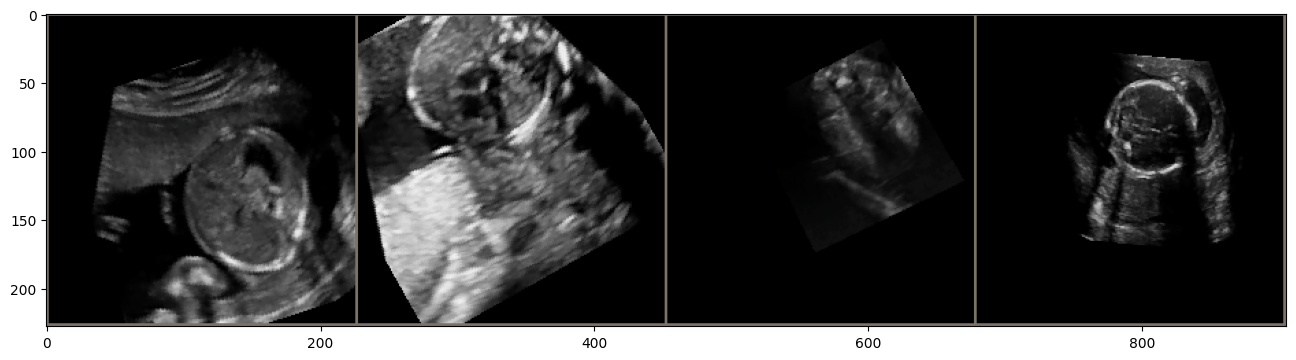

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation data examples


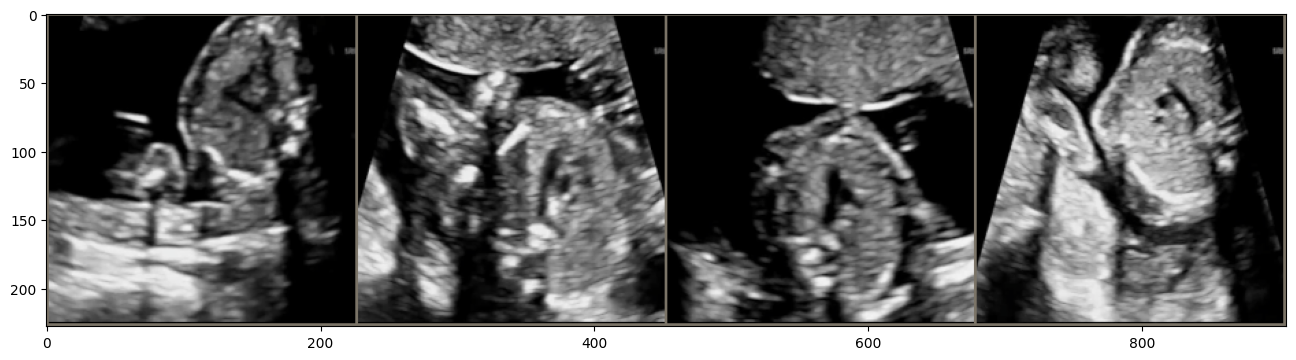

In [ ]:

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Function to show an image with specific mean and standard deviation
def imshow(img):
    """Imshow for Tensor."""
    img = img * std[..., None, None] + mean[..., None, None] # Unnormalize using your specific values
    npimg = img.numpy()
    plt.figure(figsize=(16, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
print('Train data examples')
imshow(utils.make_grid(images[:4]))


# Repeat for validation data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images

print('Validation data examples')
imshow(utils.make_grid(images[:4]))

In [ ]:
def evaluate(model, test_loader, device, epoch=0):    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not calculate gradients to save memory
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        test_loader = iter(test_loader)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = correct / total
        f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Epoch {epoch + 1}, Validataion data, Accuracy: {accuracy*100:.2f}%, F1 score : {f1:.2f}')

In [ ]:
# Load pre-trained ResNet18
model = resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)

# Check if CUDA is available and if so, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)
model = model.to(device)  # Move model to GPU if available

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    last_epoch_loss = float("inf")
    model.train()

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU if available

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update running loss
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Train Loss: {running_loss/len(train_loader)}")

    if epoch >= 4 and last_epoch_loss < 1.1 * running_loss/len(train_loader):
        print("Early stop")
        break
    else:
        last_epoch_loss = running_loss/len(train_loader)

    # evaluate(model, test_loader, device, epoch)

print('Finished Training')


device:  cuda:0


Epoch 1:  82%|████████▏ | 9/11 [00:26<00:05,  2.63s/it]/vol/bitbucket/wr323/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch 1, Train Loss: 2.741956754164262


Epoch 2: 100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Epoch 2, Train Loss: 2.3671833168376577


Epoch 3: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch 3, Train Loss: 1.9598613869060169


Epoch 4: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch 4, Train Loss: 1.6067848530682651


Epoch 5: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch 5, Train Loss: 1.2972167621959338


Epoch 6: 100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Epoch 6, Train Loss: 1.1135793165727095


Epoch 7: 100%|██████████| 11/11 [00:27<00:00,  2.48s/it]


Epoch 7, Train Loss: 0.9437105818228289


Epoch 8: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch 8, Train Loss: 0.8257800828326832


Epoch 9: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch 9, Train Loss: 0.7189015746116638


Epoch 10: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]

Epoch 10, Train Loss: 0.648786869916049
Finished Training


In [ ]:
# After training, calculate accuracy and F1 score on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy on test data: {accuracy*100:.2f}%')
print(f'Weighted F1 score on test data: {f1*100:.2f}%')

Accuracy on test data: 75.31%
Weighted F1 score on test data: 78.65%


In [ ]:
#Provided label_name_to_number 
label_number_to_name = {0: '3VV', 1: '4CH', 2: 'ABDOMINAL', 3: 'BACKGROUND', 4: 'BRAIN-CB', 5: 'BRAIN-TV', 6: 'FEMUR',
                         7: 'KIDNEYS', 8: 'LIPS', 9: 'LVOT', 10: 'PROFILE', 11: 'RVOT', 12: 'SPINE-CORONAL', 13: 'SPINE-SAGITTAL'}

desired_order = ["BRAIN-CB", "BRAIN-TV", "PROFILE", "LIPS", "ABDOMINAL", "KIDNEYS", "FEMUR", "SPINE-CORONAL", "SPINE-SAGITTAL", "4CH", "3VV", "RVOT", "LVOT", "BACKGROUND"]

# Calculate and display per-class metrics
precision, recall, f1_score, num_image = precision_recall_fscore_support(all_labels, all_predictions, average=None, zero_division=1)

results = {}
# Sort the labels to match the order in precision, recall, etc.
unique_labels = sorted(set(all_labels))  # Sort the unique labels
for label_number in unique_labels:
    label_name = label_number_to_name[label_number]
    i = unique_labels.index(label_number)  # Get the correct index
    results[label_name] = {
        'Precision': precision[i],
        'Recall': recall[i],
        'F1 Score': f1_score[i],
        '# Test Images': num_image[i],
    }

# Create a DataFrame and sort it by the desired order (same as before)
results_df = pd.DataFrame(results).T
results_df = results_df.loc[desired_order]
results_df = results_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Save results to Excel
# Generate a timestamp for the sheet name (using only minutes)
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")  # Format: Year-Month-Day_Hour-Minute
sheet_name = f"Run_{timestamp}"

# Check if the file exists
if os.path.isfile(excel_file_path):
    with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a') as writer:  
        results_df.to_excel(writer, sheet_name=sheet_name)  # Remove float_format here

        # Write additional metrics (start on the next row after the DataFrame)
        ws = writer.sheets[sheet_name]
        row_offset = len(results_df) + 3
        ws.cell(row=row_offset, column=1, value="Macro average (non-background):")
        for col_num, value in enumerate(results_df[0:13].mean(), start=2):
            ws.cell(row=row_offset, column=col_num, value=value)
        ws.cell(row=row_offset+1, column=1, value="Macro average:")
        for col_num, value in enumerate(results_df.mean(), start=2):
            ws.cell(row=row_offset+1, column=col_num, value=value)

        ws.cell(row=row_offset + 2, column=1, value="Accuracy on test data:")
        ws.cell(row=row_offset + 2, column=2, value=accuracy)  # Write accuracy in the second column

else:
    with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
        results_df.to_excel(writer, sheet_name=sheet_name) 

        # Write additional metrics (start on the next row after the DataFrame)
        ws = writer.sheets[sheet_name]
        row_offset = len(results_df) + 3
        ws.cell(row=row_offset, column=1, value="Macro average (non-background):")
        for col_num, value in enumerate(results_df[0:13].mean(), start=2):
            ws.cell(row=row_offset, column=col_num, value=value)
        ws.cell(row=row_offset+1, column=1, value="Macro average:")
        for col_num, value in enumerate(results_df.mean(), start=2):
            ws.cell(row=row_offset+1, column=col_num, value=value)

        ws.cell(row=row_offset + 2, column=1, value="Accuracy on test data:")
        ws.cell(row=row_offset + 2, column=2, value=accuracy)  # Write accuracy in the second column

# Apply custom formatting to the Excel sheet AFTER saving
wb = openpyxl.load_workbook(excel_file_path)
ws = wb[sheet_name]  # Select the sheet you just wrote to
for col in ws.iter_cols(min_col=2, max_col=4):   # Iterate over columns 2 to 4 (precision, recall, F1 score)
    for cell in col:
        cell.number_format = '0.00'  # Set number format to two decimal places

for col in ws.iter_cols(min_col=5, max_col=5):   # Iterate over columns 2 to 4 (precision, recall, F1 score)
    for cell in col:
        cell.number_format = '0'  # Set number format to two decimal places

wb.save(excel_file_path)

print(f"Results saved to '{excel_file_path}', sheet '{sheet_name}'")
print("\nPer-Class Metrics:")
print(results_df.to_markdown(floatfmt='.2f', numalign='right', stralign='left'))
print("\nMacro average (non-background):")
print(results_df[0:13].mean())
# print("\nMacro average:")
# print(results_df.mean())
print(f'Accuracy on test data: {accuracy:.4f}')

Results saved to 'Results/Ultrasound ResNet18 Spectral Dataset ResNet50TrainedEmbedding Normalized 50 50 Spectral Distance RBF 0_5 Manhattan Result.xlsx', sheet 'Run_2024-08-14_00-25-21'

Per-Class Metrics:
|                |   Precision |   Recall |   F1 Score |   # Test Images |
|:---------------|------------:|---------:|-----------:|----------------:|
| BRAIN-CB       |        0.71 |     0.89 |       0.79 |         1247.00 |
| BRAIN-TV       |        0.79 |     0.86 |       0.83 |         1743.00 |
| PROFILE        |        0.25 |     0.72 |       0.37 |          212.00 |
| LIPS           |        0.58 |     0.64 |       0.61 |         1076.00 |
| ABDOMINAL      |        0.57 |     0.73 |       0.64 |         1076.00 |
| KIDNEYS        |        0.41 |     0.73 |       0.53 |          378.00 |
| FEMUR          |        0.53 |     0.92 |       0.67 |         1034.00 |
| SPINE-CORONAL  |        0.37 |     0.84 |       0.51 |          192.00 |
| SPINE-SAGITTAL |        0.33 |     0.96 |